In [1]:
# Imports
import numpy as np 
import pandas as pd
from sklearn.metrics import confusion_matrix
from random import random
import seaborn as sn
import matplotlib.pyplot as plt
import math
import scipy

%matplotlib inline

In [2]:
# Read in the data
x_train = pd.read_csv('X_train.csv', header = None)
y_train = pd.read_csv('y_train.csv', header = None)
x_test= pd.read_csv('X_test.csv', header = None)
y_test = pd.read_csv('y_test.csv', header = None)

# Naive Bayes

In [3]:
def getBernProb(x, param):
    return (param**x)*(1-param)**(1-x)

In [4]:
def getParetoProb(x, param):
    return param*(x**(-1*(param + 1)))

In [5]:
class NaiveBayes(object):
    def __init__(self, num_classes, x_train, y_train):
        self.values_per_class = [x_train[y_train[0] == i] for i in range(num_classes)]
        self.amount_per_class = [len(self.values_per_class[i]) for i in range(len(self.values_per_class))]
        self.total = len(y_train)
        
    def getParameters(self):
        self.probability_params = {}
        for i in range(len(self.values_per_class)):
            params = self.values_per_class[i].mean()
            pareto_num = len(self.values_per_class[i])
            pareto_denom = (np.log(self.values_per_class[i][list(self.values_per_class[i].columns[54:57])]).sum())
            params.update(pareto_num/pareto_denom)
            self.probability_params[i] = params

    def getProbabilities(self, input_vec):
        probabilities = []
        class_num = 0
        for class_val, param in self.probability_params.items():
            probability = self.amount_per_class[class_num]/self.total # CHANGE TO USE CLASS PROBABILITY
            for i in range(len(param)):
                if i < 54:
                    probability *= getBernProb(input_vec[i], param[i])
                else:
                    probability *= getParetoProb(input_vec[i], param[i])
            probabilities.append(probability)
            class_num += 1
        return probabilities
    
    def predict(self, input_vec):
        probabilities = self.getProbabilities(input_vec)
        return probabilities.index(max(probabilities))
    
    def getAllPredictions(self, test_set):
        return [self.predict(feature_vec[1]) for feature_vec in test_set.iterrows()]

    def getPredictionAccuracy(self, predictions, y_test):
        prediction_matrix = confusion_matrix(y_test, predictions, labels = [0, 1])
        accuracy = np.diagonal(prediction_matrix).sum()/len(predictions)*100
        return (accuracy, prediction_matrix)
        

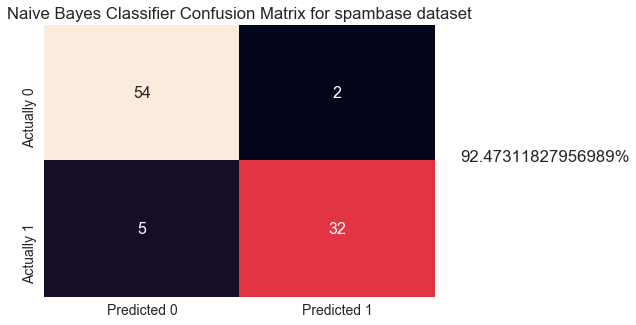

In [6]:
naive_bayes = NaiveBayes(2, x_train, y_train)
naive_bayes.getParameters()
predictions = naive_bayes.getAllPredictions(x_test)
accuracy, matrix = naive_bayes.getPredictionAccuracy(predictions, y_test)
condusion_matrix = pd.DataFrame(matrix, range(2), range(2))
plt.figure(figsize = (7,5))
sn.set(font_scale=1.4)
sn.heatmap(condusion_matrix, annot=True, annot_kws={"size": 16}, cbar = False, 
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels = ['Actually 0', 'Actually 1'])
plt.figtext(.95, .5, '{0}%'.format(accuracy), rotation='horizontal')
plt.title('Naive Bayes Classifier Confusion Matrix for spambase dataset')


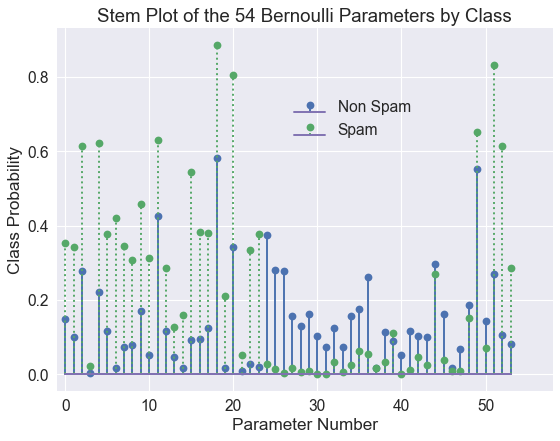

In [16]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
markerline, stemlines, baseline = plt.stem(naive_bayes.probability_params[0][:54], markerfmt='o', label='Non Spam')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
markerline, stemlines, baseline = plt.stem(naive_bayes.probability_params[1][:54], markerfmt='o', label='Spam')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
plt.setp(stemlines, 'linestyle', 'dotted')
plt.legend(loc='center left', bbox_to_anchor=(.45, 0.75))
plt.title('Stem Plot of the 54 Bernoulli Parameters by Class')
plt.xlabel('Parameter Number')
plt.ylabel('Class Probability')
plt.xlim([-1,58]);


## Nearest Neighbors

In [8]:
def manhattanDistance(vec1, vec2):
    return abs(vec1-vec2).sum()

In [9]:
class NearestNeighbors(object):
    def __init__(self, k_limit, distance_function, x_train, y_train):
        self.k_limit = k_limit
        self.distance_function = distance_function
        self.data = x_train
        self.labels = y_train
        
    def getNeighbors(self, input_vec):
        distances = pd.DataFrame(np.apply_along_axis(self.distance_function, 1, self.data, input_vec))   
        nearest = distances.sort_values(0)[:self.k_limit]
        return np.ravel(self.labels.loc[nearest.index])
    
    def predict(self, neighbors, k_val):
        class1 = np.sum(neighbors[:k_val])
        class0 = abs(class1 - k_val)
        if class1 > class0: return 1
        elif class1 < class0: return 0
        else: return int(random())
    
    def getAllNeighbors(self, test_set):
        self.all_neighbors = np.apply_along_axis(self.getNeighbors, 1, test_set)
    
    def predictAll(self, test_set):
        self.getAllNeighbors(test_set)
        self.all_predictions = []
        for k in range(1, self.k_limit+1):
            self.all_predictions.append(pd.DataFrame(np.apply_along_axis(self.predict, 1, pd.DataFrame(self.all_neighbors), k)))
                
    def getAccuracy(self, test_labels):
        return [((self.all_predictions[i] == test_labels).sum())/len(test_labels) for i in range(self.k_limit)]

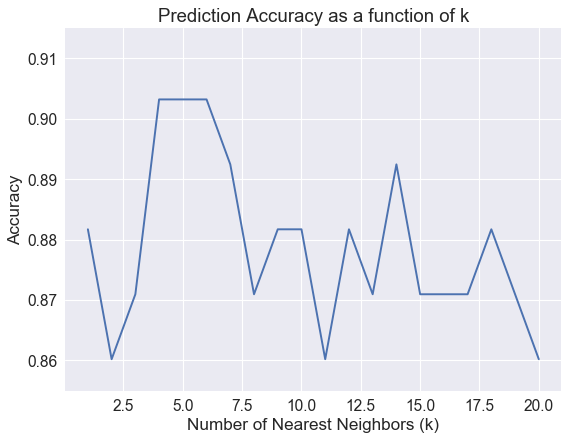

In [17]:
nearest_neighbors = NearestNeighbors(20, manhattanDistance, x_train, y_train)
nearest_neighbors.predictAll(x_test)
knn_accuracy = nearest_neighbors.getAccuracy(y_test)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(list(range(1, 21)), knn_accuracy)
plt.title('Prediction Accuracy as a function of k')
plt.xlabel('Number of Nearest Neighbors (k)')
plt.ylabel('Accuracy')
plt.ylim([.855,.915]);

## Logistic Regresssion

In [11]:
class LogsiticRegression(object):
    def __init__(self, x_train, y_train):
        x_train[len(y_train)] = 1
        self.x = x_train.as_matrix()
        self.y = pd.DataFrame(y_train[0].replace(0,-1,inplace=False)).as_matrix()
        self.xy = self.y * self.x
        
    def steepestAscent(self, iterations):
        w = np.zeros(shape = (58,1))
        xyw = np.dot(self.xy, w)
        self.objectives = []
        for t in range(1, iterations+1):
            eta = (1/(10**5 * np.sqrt(t+1)))
            w += pd.DataFrame(eta*self.getGradient(xyw))
            xyw = np.dot(self.xy, w)
            self.objectives.append(self.getObjective(xyw))
        self.w = w
        
    def newtonsMethod(self, iterations):
        w = np.zeros(shape = (58,1))
        xyw = np.dot(self.xy, w)
        self.objectives = []
        for t in range(1, iterations+1):
            eta = (1/(np.sqrt(t+1)))
            gradient = self.getGradient(xyw)
            
            xw = np.dot(self.x, w)
            
            hessian_inv = np.linalg.inv(pd.DataFrame(self.getHessian(xw)))
            step = np.dot(hessian_inv, gradient)
            
            w -= pd.DataFrame(eta*step)
            xyw = np.dot(self.xy, w)

            self.objectives.append(self.getObjective(xyw))
        self.w = w
    
    def getGradient(self, xyw):
        sigs = 1 - scipy.special.expit(xyw)
        return np.sum(sigs*self.xy, axis = 0)
    
    def getHessian(self, xw):
        sigmoids = scipy.special.expit(xw)
        sig_product = sigmoids*(1-sigmoids)
        x_product = sig_product.T*self.x.T
        hessian = -1*np.dot(x_product, self.x)
        return hessian
        
    def getObjective(self, val):
        return np.sum(np.ma.log(scipy.special.expit(val)))
    
    def predict(self, test_set):
        test_set[57]=1
        sigmoids = scipy.special.expit(np.dot(test_set, self.w))
        self.predictions = [1 if sigmoid >= 0.5 else -1 for sigmoid in sigmoids]

    def getAccuracy(self, test_labels):
        test_labels = pd.DataFrame(test_labels[0].replace(0,-1,inplace=False))
        return (self.predictions == test_labels).sum()/len(self.predictions)*100

In [12]:
logistic_regression = LogsiticRegression(x_train, y_train)
logistic_regression.steepestAscent(10000)

(-100, 10100)

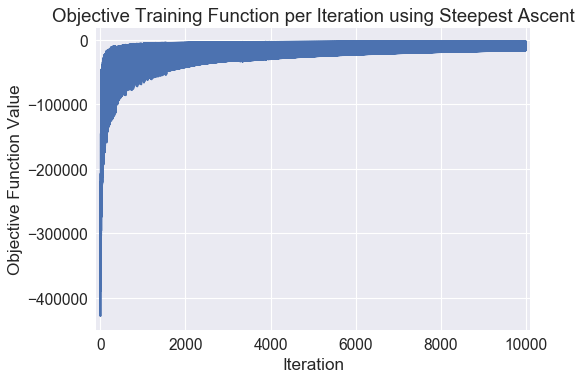

In [13]:
plt.figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(list(range(1, 10001)), logistic_regression.objectives)
plt.title('Objective Training Function per Iteration using Steepest Ascent')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.xlim([-100,10100]);

In [14]:
logistic_regression.newtonsMethod(100)
logistic_regression.predict(x_test)

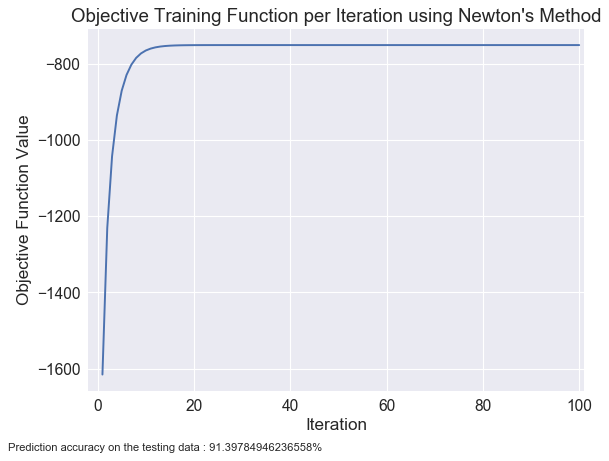

In [18]:
logistic_accuracy = logistic_regression.getAccuracy(y_test)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(list(range(1, 101)), logistic_regression.objectives)
plt.title("Objective Training Function per Iteration using Newton's Method")
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.figtext(0.00001, 0.00001, 'Prediction accuracy on the testing data : {0}%'.format(float(logistic_accuracy)), size = 10)
plt.xlim([-2,101]);